### Objectives

First, create a graph representation of the information we have. 
This would be information about the elements, and the nodes. 
Using this, we will feed it into our SVM, or a Random Forest, and see from there onwards

In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
from Generate_Excel import *
from MitoCode_Functions import open_file_dialog

In [3]:
import pandas as pd
import igraph as ig

def Mitograph_Graph(FileName):
    # Read information from the gnet file, and create a graph object
    # generate a function that takes in the filename and gives out the graph
    G = pd.read_table(FileName + '.gnet', skiprows=1, sep='\t', names=['Source', 'Target', 'Length'])
    graph = ig.Graph.TupleList(G.itertuples(index=False), directed=False, edge_attrs=['Length'])
    layout = graph.layout_auto()  # Automatic layout calculation
    graph.vs['degree'] = graph.degree()
    # ig.plot(graph, layout=layout)
    Vol = pd.read_table(FileName + '.cc', skiprows=0, sep='\t')
    Vol.columns = ['node', 'cc', 'vol_cc']

    ids = [int(node['name']) for node in graph.vs]
    graph.vs['cc_vol'] = [Vol.loc[Vol['node'] == node, 'vol_cc'].values[0] for node in ids]
    graph.vs['cc'] = [Vol.loc[Vol['node'] == node, 'cc'].values[0] for node in ids]
    return graph, Vol

In [4]:


# df_dir_2 = open_file_dialog()[0]
# df = pd.read_csv(df_dir_2)


In [5]:
a, p, c, n, f = Generate_Mito_Tables(open_folder_dialog())

FileNotFoundError: [Errno 2] No such file or directory: ''

In [5]:
n = pd.read_csv(open_file_dialog()[0])
df = pd.read_csv(open_file_dialog()[0])

In [6]:
cc_df = df[['cc_x', 'folder_name_x', 'cc_pixel_intensity_488', 'cc_pixel_intensity_405', 'cc_pixel_intensity_555', 'cc_pixel_intensity_ratio', 'cc_average_degree_excludeFreeEnds',
             'cc_max_PK', 'diameter', 'cc_vol_from_img_(um3)', 'branches'
            , 'nodes', 'edges']].drop_duplicates(subset = ['cc_x','folder_name_x'])

In [7]:
cc_df = df[['cc_x', 'folder_name_x', 'cc_pixel_intensity_488', 'cc_pixel_intensity_405', 'cc_pixel_intensity_555', 'cc_pixel_intensity_ratio', 'cc_average_degree_excludeFreeEnds',
             'cc_max_PK', 'diameter', 'cc_vol_from_img_(um3)', 'branches'
            , 'nodes', 'edges']].drop_duplicates(subset = ['cc_x','folder_name_x'])

ele_df = df[['line_id', 'folder_name_x', 'element_pixel_intensity_488', 'element_pixel_intensity_405', 'element_pixel_intensity_555', 
            'element_pixel_intensity_ratio', 'element_Volume_Voxel', 'element_length_(um)', 'element_average_width' ]].drop_duplicates(subset=['line_id', 'folder_name_x'])

In [ ]:
ele_df.drop(['line_id', 'folder_name_x', 'element_pixel_intensity_555'], axis = 1)

,element_pixel_intensity_488,element_pixel_intensity_405,element_pixel_intensity_ratio,element_Volume_Voxel,element_length_(um),element_average_width
0,400.375000,31.687500,0.079145,0.395035,1.563550,0.252653
4,245.700000,42.200000,0.171754,0.072792,0.421737,0.172600
9,897.437500,41.000000,0.045686,0.414276,2.014889,0.205607
13,884.785714,41.107143,0.046460,0.319226,1.307177,0.244210
20,709.788462,34.269231,0.048281,0.648523,2.133120,0.304025
...,...,...,...,...,...,...
259458,521.625000,13.250000,0.025401,0.047226,0.330596,0.142852
259462,499.416667,21.583333,0.043217,0.036582,0.208000,0.175873
259465,438.035714,39.107143,0.089278,0.228966,0.874160,0.261927
259472,327.625000,20.750000,0.063335,0.058393,0.312000,0.187158


In [10]:
ele_corr = ele_df.drop(['line_id', 'folder_name_x', 'element_pixel_intensity_555'], axis = 1).corr()
ele_corr.to_csv('element_corr.csv')

In [11]:
cc_corr = cc_df.drop(['cc_x', 'folder_name_x'], axis = 1).corr()
cc_corr.to_csv('cc_corr.csv')

In [ ]:
cc_df

,cc_x,folder_name_x,cc_pixel_intensity_488,cc_pixel_intensity_405,cc_pixel_intensity_555,cc_pixel_intensity_ratio,cc_average_degree_excludeFreeEnds,cc_max_PK,diameter,cc_vol_from_img_(um3),branches,nodes,edges
0,0,Tol1hr3_2_S2,400.375000,31.687500,381.375000,0.079145,0.000000,0,0.273622,0.09194,1,2,1
4,1,Tol1hr3_2_S2,245.700000,42.200000,251.800000,0.171754,0.000000,2,0.383322,0.04867,1,2,1
9,2,Tol1hr3_2_S2,868.068120,50.390327,729.465032,0.058049,2.071429,9,0.484119,45.07027,60,140,175
1126,3,Tol1hr3_2_S2,715.049684,42.017089,612.081013,0.058761,1.850467,8,0.497718,31.25283,48,107,123
1923,4,Tol1hr3_2_S2,262.500000,4.062500,139.500000,0.015476,0.000000,2,0.514636,0.06490,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
259458,57,TCDD10nM4hr_5_4_S,521.625000,13.250000,172.125000,0.025401,0.000000,2,0.408182,0.04326,1,2,1
259462,58,TCDD10nM4hr_5_4_S,499.416667,21.583333,166.666667,0.043217,0.000000,2,0.481408,0.03786,1,2,1
259465,59,TCDD10nM4hr_5_4_S,438.035714,39.107143,137.357143,0.089278,0.000000,2,0.477941,0.15683,1,2,1
259472,60,TCDD10nM4hr_5_4_S,327.625000,20.750000,154.250000,0.063335,0.000000,2,0.420166,0.04326,1,2,1


In [ ]:
eledf = df[['line_id', 'cc_x', 'element_Volume_Voxel', 'element_pixel_intensity_405', 'element_length_(um)', 'element_pixel_intensity_488', 'element_pixel_intensity_555' 
            ,'element_pixel_intensity_ratio', 'element_average_width', 'folder_name_x']].drop_duplicates(subset=['line_id', 'folder_name_x'])

# rename folder_name_x to folder_name in eledf
# eledf.rename(columns={'folder_name_x': 'folder_name'}, inplace=True)
bigDf = pd.merge(bigDf, eledf, how='left', left_on=['line_id', 'folder_name'], right_on=['line_id', 'folder_name_x'])

KeyError: "['element_Volume_Voxel', 'element_pixel_intensity_405', 'element_length_(um)', 'element_pixel_intensity_488', 'element_pixel_intensity_555', 'element_pixel_intensity_ratio', 'element_average_width', 'folder_name_x'] not in index"

In [12]:
df

,Unnamed: 0,cc_x,cc_length_(um),cc_vol_from_img_(um3),branches,nodes,edges,cc_pixel_intensity_ratio,cc_pixel_intensity_488,cc_pixel_intensity_405,...,z_y,node,degree,cc_y,vol_cc,avg_PK_Of_element,element_connectivity,folder_name_y,coeff_of_variance_cc,coeff_of_variance_line_id
0,0,0,1.56355,0.09194,1,2,1,0.079145,400.375,31.6875,...,2.0,312.0,1.0,0.0,0.00000,1.0,1.0,Tol1hr3_2_S2,67.115979,53.268613
1,1,0,1.56355,0.09194,1,2,1,0.079145,400.375,31.6875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.115979,53.268613
2,2,0,1.56355,0.09194,1,2,1,0.079145,400.375,31.6875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.115979,53.268613
3,3,0,1.56355,0.09194,1,2,1,0.079145,400.375,31.6875,...,3.5,201.0,1.0,38.0,0.09194,1.0,1.0,Tol1hr3_2_S2,67.115979,53.268613
4,4,1,0.42174,0.04867,1,2,1,0.171754,245.700,42.2000,...,9.5,1.0,1.0,1.0,0.04867,1.0,1.0,Tol1hr3_2_S2,49.668895,57.450571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259475,413,60,0.31200,0.04326,1,2,1,0.063335,327.625,20.7500,...,1.5,114.0,1.0,60.0,0.04326,1.0,1.0,TCDD10nM4hr_5_4_S,59.988137,52.452222
259476,414,61,0.31200,0.04867,1,2,1,0.051319,431.125,22.1250,...,1.5,121.0,1.0,61.0,0.04867,1.0,1.0,TCDD10nM4hr_5_4_S,52.899249,51.663003
259477,415,61,0.31200,0.04867,1,2,1,0.051319,431.125,22.1250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.899249,51.663003
259478,416,61,0.31200,0.04867,1,2,1,0.051319,431.125,22.1250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.899249,51.663003


In [ ]:
bigDf = bigDf[['line_id', 'folder_name_x', 'node', 'node_2', 'element_pixel_intensity_488', 'element_pixel_intensity_405', 'element_pixel_intensity_555', 'element_length_(um)', 'element_average_width']]

KeyError: "['folder_name_x', 'node', 'node_2', 'element_pixel_intensity_488', 'element_pixel_intensity_405', 'element_pixel_intensity_555', 'element_length_(um)', 'element_average_width'] not in index"

In [ ]:
cc_df = df.drop_duplicates(subset=['cc_x', 'folder_name'])

KeyError: Index(['folder_name'], dtype='object')

In [ ]:
df.columns

Index(['cc_x', 'cc_pixel_intensity_488', 'cc_pixel_intensity_405',
       'element_pixel_intensity_ratio', 'element_pixel_intensity_488',
       'element_pixel_intensity_405', 'element_length_(um)',
       'element_average_width', 'branches', 'nodes', 'edges', 'cc_max_PK',
       'cc_length_(um)'],
      dtype='object')

In [ ]:
df.drop(['folder_name_x', 'line_id'], axis=1, inplace=True)

/tmp/ipykernel_416380/698579016.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['folder_name_x', 'line_id'], axis=1, inplace=True)


In [ ]:
df.drop('cc_pixel_intensity_488', axis=1, inplace=True)

/tmp/ipykernel_416380/3937549250.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('cc_pixel_intensity_488', axis=1, inplace=True)


In [ ]:
df

,cc_pixel_intensity_405,branches,nodes,edges,cc_max_PK,cc_length_(um)
0,19.500000,1,2,1,2,0.87492
6,22.156250,1,2,1,2,0.93847
14,12.906250,1,2,1,2,0.97180
22,6.250000,1,2,1,2,0.23586
25,7.312500,1,2,1,2,0.31200
...,...,...,...,...,...,...
2091,31.500000,1,2,1,2,0.42324
2095,10.333333,1,2,1,2,0.20800
2098,30.000000,1,2,1,2,0.23586
2101,41.500000,1,2,1,2,0.20800


In [ ]:
graph = ig.Graph.TupleList(bigDf.itertuples(index=False), directed=False, edge_attrs=['line_id', 'element_pixel_intensity_ratio', 'element_pixel_intensity_405', 'element_length_(um)', 'element_pixel_intensity_488'])

# ids = [int(node['name']) for node in graph.vs]
# graph.vs['cc_vol'] = [df.loc[df['node'] == node, 'degree'].values[0] for node in ids]
# graph.vs['488'] = [df.loc[df['node'] == node, 'pixel_intensity_488'].values[0] for node in ids]
# graph.vs['405'] = [df.loc[df['node'] == node, 'pixel_intensity_405'].values[0] for node in ids]
# graph.vs['ratio'] = [df.loc[df['node'] == node, 'pixel_intensity_ratio'].values[0] for node in ids]
# graph.vs['structural'] = [df.loc[df['node'] == node, 'pixel_intensity_555'].values[0] for node in ids]

In [ ]:
df.drop_duplicates(subset=['line_id', 'folder_name_x', 'cc_x'], inplace=True)

KeyError: Index(['line_id', 'folder_name_x'], dtype='object')

In [ ]:
corr = df.corr()

In [28]:
cc_df = df[['cc_x', 'folder_name_x', 'cc_pixel_intensity_488', 'cc_pixel_intensity_405', 'cc_pixel_intensity_555', 'cc_pixel_intensity_ratio', 'cc_average_degree_excludeFreeEnds',
             'cc_max_PK', 'diameter', 'cc_vol_from_img_(um3)', 'branches'
            , 'nodes', 'edges']].drop_duplicates(subset = ['cc_x','folder_name_x'])

ele_df = df[['line_id', 'folder_name_x', 'element_pixel_intensity_488', 'element_pixel_intensity_405', 'element_pixel_intensity_555', 
            'element_pixel_intensity_ratio', 'element_Volume_Voxel', 'element_length_(um)', 'element_average_width' ]].drop_duplicates(subset=['line_id', 'folder_name_x'])

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report


In [34]:
# make cc_df only the first 1000 entries 
cc_df = cc_df[:500]

In [35]:
cc_df

,cc_x,folder_name_x,cc_pixel_intensity_488,cc_pixel_intensity_405,cc_pixel_intensity_555,cc_pixel_intensity_ratio,cc_average_degree_excludeFreeEnds,cc_max_PK,diameter,cc_vol_from_img_(um3),branches,nodes,edges
0,0,Tol1hr3_2_S2,400.375000,31,381.375000,0.079145,0.000000,0,0.273622,0.09194,1,2,1
4,1,Tol1hr3_2_S2,245.700000,42,251.800000,0.171754,0.000000,2,0.383322,0.04867,1,2,1
9,2,Tol1hr3_2_S2,868.068120,50,729.465032,0.058049,2.071429,9,0.484119,45.07027,60,140,175
1126,3,Tol1hr3_2_S2,715.049684,42,612.081013,0.058761,1.850467,8,0.497718,31.25283,48,107,123
1923,4,Tol1hr3_2_S2,262.500000,4,139.500000,0.015476,0.000000,2,0.514636,0.06490,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13071,61,Tol1hr3_4_S,430.687500,35,171.000000,0.082717,0.000000,2,0.443369,0.09734,1,2,1
13075,62,Tol1hr3_4_S,424.045455,32,172.090909,0.077018,0.750000,3,0.601202,0.49754,3,4,3
13087,63,Tol1hr3_4_S,434.448276,28,178.206897,0.065581,1.500000,6,0.445178,0.68682,2,4,4
13117,64,Tol1hr3_4_S,263.333333,24,130.708333,0.093196,0.000000,2,0.357195,0.16224,1,2,1


In [36]:
cc_df['cc_pixel_intensity_405'] = cc_df['cc_pixel_intensity_405'].astype(int)

/tmp/ipykernel_10709/4177657149.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cc_df['cc_pixel_intensity_405'] = cc_df['cc_pixel_intensity_405'].astype(int)


In [51]:
X = cc_df.drop(['cc_pixel_intensity_405', 'cc_x', 'folder_name_x', 'cc_pixel_intensity_555', 'cc_pixel_intensity_ratio'], axis=1)  # Adjust 'target_column' to your actual target column name
y = cc_df['cc_pixel_intensity_405']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



svm_model = SVC(kernel='linear')  # You can choose different kernels like 'rbf', 'poly', etc.
svm_model.fit(X_train, y_train)


SVC(kernel='linear')

In [52]:
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(accuracy)

0.07


/home/mitosim2/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mitosim2/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mitosim2/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mitosim2/.local/lib/python3.10/si

Text(0, 0.5, 'pred')

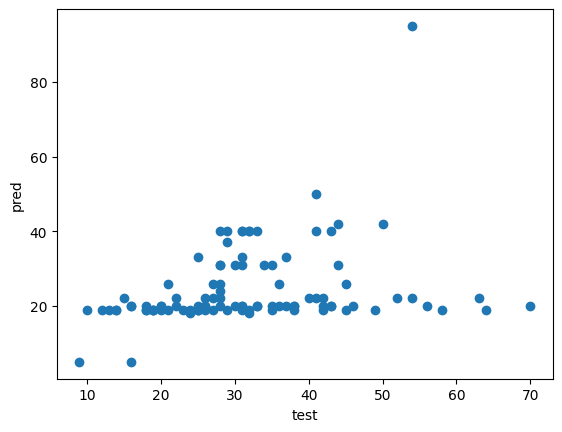

In [53]:
plt.scatter(y_test, y_pred)
plt.xlabel('test')
plt.ylabel('pred')

In [ ]:
# ele_df['element_pixel_intensity_405'] = ele_df['element_pixel_intensity_405'].astype(int)

# X = ele_df.drop(['element_pixel_intensity_405', 'line_id', 'folder_name_x', 'element_pixel_intensity_555', 'element_pixel_intensity_ratio'], axis=1)  # Adjust 'target_column' to your actual target column name
# y = ele_df['element_pixel_intensity_405']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# svm_model = SVC(kernel='linear')  # You can choose different kernels like 'rbf', 'poly', etc.
# svm_model.fit(X_train, y_train)


/home/mitosim2/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mitosim2/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mitosim2/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mitosim2/.local/lib/python3.10/si

In [ ]:
accuracy

0.023166023166023165